# Playground with sampled data from KiT-RT

### Setup

In [1]:
using KitBase, Plots, JLD2, Distributions, LinearAlgebra, Flux
using Flux: @epochs

┌ Info: Kinetic will run serially
└ @ KitBase /home/steffen/.julia/packages/KitBase/GHBg7/src/KitBase.jl:52


In [2]:
function regime_data(w, sw, f, u, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 1)
    prim = conserve_prim(w, gam)
    Mu, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, sw, K)
    swt = -prim[1] .* moments_conserve_slope(a, Mu, Mxi, 1)
    A = pdf_slope(prim, swt, K)
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, prim, a, A, tau)
    L = norm((f .- fr) ./ prim[1])

    x = [w; sw; tau]
    y = ifelse(L <= 0.005, 0.0, 1.0)
    return x, y
end

function regime_number(Y, rg=0)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

function accuracy(nn, X, Z)
    Z1 = nn(X)

    ZA1 = [round(Z1[1, i]) for i in axes(Z1, 2)]
    ZA = [round(Z[1, i]) for i in axes(Z, 2)]

    accuracy = 0.0
    for i in eachindex(ZA)
        if ZA[i] == ZA1[i]
            accuracy += 1.0
        end
    end
    accuracy /= length(ZA)

    return accuracy
end

accuracy (generic function with 1 method)

### Dataset

In [1]:
file = open("maxwellians.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[3:end];

In [3]:
#=file = open("../../../data/1d/a3_ev10.csv")
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = [pdfs; data[3:end]]
=#
#=file = open("../../../data/1d/a8_ev5.csv")
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = [pdfs; data[3:end]]=#
nd = length(pdfs) ÷ 2
pdfs

3-element Vector{Any}:
 [8.946029754839564e-23, 1.1137511563171871e-22, 1.526651056471984e-22, 2.3011909907027386e-22, 3.8082994745747227e-22, 6.905902187343372e-22, 1.369022933827297e-21, 2.9589716090693077e-21, 6.951887715074634e-21, 1.7694858598626076e-20  …  6.951887715074634e-21, 2.9589716090693077e-21, 1.369022933827297e-21, 6.905902187343372e-22, 3.8082994745747227e-22, 2.3011909907027386e-22, 1.526651056471984e-22, 1.1137511563171871e-22, 8.946029754839564e-23, 7.918025195246115e-23]
 [5.35976571288529e-25, 6.74642910443974e-25, 9.395276642826706e-25, 1.4458176665481158e-24, 2.4546034969397418e-24, 4.588255236266843e-24, 9.420834743081027e-24, 2.1189987583147986e-23, 5.205311297820145e-23, 1.391774936153889e-22  …  7.230780367660113e-19, 3.2179350463573835e-19, 1.549381766812368e-19, 8.095052251394148e-20, 4.601582540679366e-20, 2.8524509329407884e-20, 1.9319521793335814e-20, 1.4319529698268503e-20, 1.1628969996680376e-20, 1.0355732991483562e-20]
 [5.35976571288529e-25, 6.74642

In [4]:
vs = VSpace1D(-5.0, 5.0, length(data[1]), data[1], data[1][2:end] .- data[1][1:end-1], data[2])
δ = heaviside.(vs.u);

LoadError: UndefVarError: VSpace1D not defined

In [6]:
dist = Uniform(0.005, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.0001, 1.0)
kns = rand(dist, nd);
dist = Uniform(0.1, 1.0)
rhos = rand(dist, nd);

In [7]:
X = [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
Y = [0.0]
for i = 1:nd
    try
        #fL = pdfs[i]; fR = pdfs[nd*2-i]
        fL = pop!(pdfs) .* pop!(rhos); fR = pop!(pdfs) .* pop!(rhos) # shuffle
        wL = moments_conserve(fL, vs.u, vs.weights); wR = moments_conserve(fR, vs.u, vs.weights)
        #@show wL, wR
        
        f = @. fL * δ + fR * (1.0 - δ)
        w = moments_conserve(f, vs.u, vs.weights)
        #f = @. (fL + fR) / 2
        #w = @. (wL + wR) / 2
        
        sw = @. (wR - wL) / dxs[i]
        
        tmpx, tmpy = regime_data(w, sw, f, vs.u, 0, kns[i])
        X = hcat(X, tmpx)
        Y = hcat(Y, tmpy)
    catch
    end
end

In [8]:
regime_number(Y)

NS regime: 99 of 7500


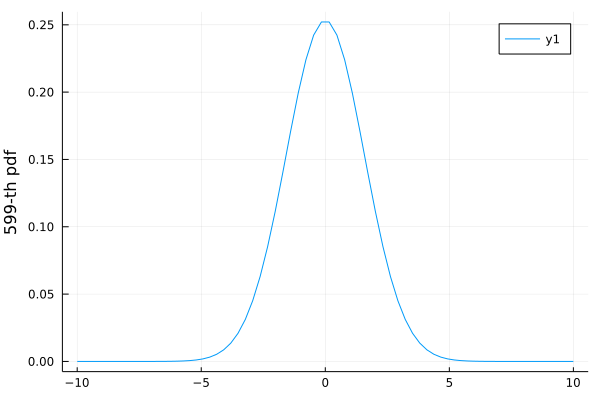

In [9]:
idx = Int(floor(rand() * size(X, 2)))
plot(data[1], data[idx], ylabel="$(idx)-th pdf")

### Model

In [10]:
@load "../nn_scalar.jld2" nn

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /home/steffen/.julia/packages/JLD2/qncOK/src/JLD2.jl:204


LoadError: SystemError: opening file "../nn_scalar.jld2": No such file or directory

In [11]:
accuracy(nn, X, Y)

LoadError: UndefVarError: nn not defined

In [12]:
data = Flux.Data.DataLoader((X, Y), shuffle = true)
ps = Flux.params(nn)
sqnorm(x) = sum(abs2, x)
#loss(x, y) = sum(abs2, nn(x) - y) / size(x, 2) #+ 1e-6 * sum(sqnorm, ps)
loss(x, y) = Flux.binarycrossentropy(nn(x), y)
cb = () -> println("loss: $(loss(X, Y))")
opt = ADAM()

LoadError: UndefVarError: nn not defined

In [13]:
@epochs 2 Flux.train!(loss, ps, data, opt, cb = Flux.throttle(cb, 1))

┌ Info: Epoch 1
└ @ Main /home/steffen/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


LoadError: UndefVarError: cb not defined

In [14]:
cd(@__DIR__)
@save "nn_rif.jld2" nn # reinforcement neural model

LoadError: UndefVarError: nn not defined

### Test

In [15]:
accuracy(nn, X, Y)

LoadError: UndefVarError: nn not defined

In [16]:
nn(X)

LoadError: UndefVarError: nn not defined

In [17]:
X

7×7500 Matrix{Float64}:
 1.0   0.403813   0.524493   0.549724  …   0.615919      0.507578
 0.0  -0.282637  -0.354264  -0.125001     -0.480766      0.175203
 1.0   0.507493   0.644795   0.683722      0.763739      0.629397
 0.0   8.88818   38.4447    10.2233       24.7939       -5.91408
 0.0  -0.178203   0.644311  -0.117524     -4.94324e-16   1.73107e-17
 0.0  11.0223    47.697     12.6567    …  30.7444       -7.33346
 1.0   1.57405    1.14339    0.225361      1.31266       0.233489

In [18]:
Y

1×7500 Matrix{Float64}:
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0